In [1]:
using Markdown
using InteractiveUtils
using Plots
using NNlib # directly invoking NN primitives used by Flux
#maybe use this always instead, if Flux has higher overhead (compilation, performance)
using DSP #signal processing pkg for standard conv operations
using BenchmarkTools
using Flux

In [3]:
#define grid
M = 10;
N = 10;
Δx = 0.5;
Δy = 0.5;
xl = Int64(M/Δx + 1);
yl = Int64(N/Δy + 1);
xx = collect(0:Δx:M);
yy = collect(0:Δy:N);
xgrid = repeat(xx,1,xl);
ygrid = repeat(yy,1,yl);

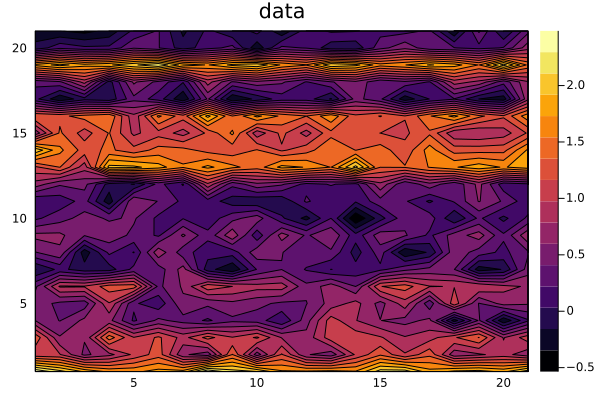

In [4]:
ϕ = abs.(sin.(randn(xl,yl) * xgrid) + cos.(randn(xl,yl) * ygrid)) +0.25*randn(xl,yl);
#modified ϕ with extra channel and batch dimensions for conv layer
ϕconv = Float32.(reshape(ϕ,(xl,yl,1,1)));
#conv ϕ with extra padding for first order derivative at the bdry.
p1 = contourf(ϕ, title="data")

In [5]:
ϕ

21×21 Matrix{Float64}:
  2.47084     2.18583     1.89057    …   2.00643    1.87532    2.23663
  1.02129     0.989068    0.551252       0.757569   0.86533    0.65174
  1.3081      0.617207    0.61518        1.35832    0.772045   1.08556
  0.597744    0.3995      0.644845       0.43494   -0.314818   0.197377
  0.513078    0.358639    0.302177       0.396988   0.676729   0.619476
  0.363487    1.0001      0.995518   …   0.969358   0.840485   0.761392
 -0.166767    0.0873821  -0.0719211     -0.259218  -0.144771   0.510824
  0.397974    0.561415   -0.275846       0.323546   0.166424   0.387967
  0.651691    0.641997    0.419935       0.689017   0.250084   0.756146
  0.180568    0.332158    0.481406       0.259985  -0.0202942  0.258557
  0.0390735   0.10541     0.294726   …   0.609504   0.381494   0.0883764
  0.7054      0.432664    0.468633       0.659071   0.108057   0.18375
  1.12656     1.35767     0.867814       1.8431     1.70958    1.84076
  2.06441     1.58645     1.26896        1.27

In [6]:
ϕconvPadded = Array{Float64}(undef,xl+2,yl+2)
ϕconvPadded[2:end-1,2:end-1] = copy(ϕ)
#rows
ϕconvPadded[1,2:end-1] = ϕconvPadded[2,2:end-1]
ϕconvPadded[end,2:end-1] = ϕconvPadded[end-1,2:end-1]
#columns
ϕconvPadded[2:end-1,1] = ϕconvPadded[2:end-1,2]
ϕconvPadded[2:end,end] = ϕconvPadded[2:end,end-1]
ϕconvPadded = Float32.(reshape(ϕconvPadded,(xl+2,yl+2,1,1)));

## Computing $\partial$ derivatives with Convolutional Layers 

### Compute with Finite Difference method for validation

In [8]:
begin
	#2nd derivative with FDM Central Difference
	∂x2 = Array{Float64}(undef,xl,yl);

	for i=2:xl-1
		∂x2[i,:] = (ϕ[i+1,:] - 2*ϕ[i,:] + ϕ[i-1,:]) ./ (Δx^2);
	end
	∂x2[1,:] = (ϕ[2,:] - ϕ[1,:]) ./ (Δx^2);
	∂x2[end,:] = (ϕ[end,:] - ϕ[end-1,:]) ./ (Δx^2);
end

21-element Vector{Float64}:
 -0.5440086809766006
 -2.040412252194583
 -1.9337390961482508
 -1.4549096015694731
 -1.2220612408755174
  0.01376031136045408
 -0.4981187583142407
 -0.29031597067364406
 -1.6398140682192057
  1.6651200634390695
 -2.4012914241196297
 -0.28573272275529993
  1.3406140442958705
  1.3567581902964594
 -0.7514877253942146
 -1.5462252733017734
 -0.0972468772904489
 -2.218545268782507
  1.140319532779384
 -1.6412626314883618
 -1.4133376342135102

## ∂ϕ/∂x2 Derivative with Conv layers - with Flux, NNlib and DSP pkgs

### a) Flux Conv: Init Conv with explicit weights for FDM kernel ∂ϕ/∂x2

In [10]:
begin
	centralDiff2ndFDM∂x = [0 1.0 0;0 -2.0 0;0 1.0 0] ./ (Δx^2);
	centralDiff2ndFDM∂x = Float32.(reshape(centralDiff2ndFDM∂x,(3,3,1,1)))
end

3×3×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0   4.0  0.0
 0.0  -8.0  0.0
 0.0   4.0  0.0

In [11]:
#weight = rand(3,3,1,1);
#weight = copy(ps1[1]); #using method 1 weights for testing 
weight∂x = centralDiff2ndFDM∂x #using 2nd order Central Difference Kernel

3×3×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0   4.0  0.0
 0.0  -8.0  0.0
 0.0   4.0  0.0

In [12]:
bias∂x = zeros(1)

1-element Vector{Float64}:
 0.0

In [13]:
convLayer∂x2 = Flux.Conv(weight∂x,bias∂x,identity; pad=1)

Conv((3, 3), 1 => 1, pad=1)  # 10 parameters

In [15]:
begin
	ps2 = Flux.params(convLayer∂x2);
	size(ps2[1]);
end

(3, 3, 1, 1)

In [16]:
conv∂x2 = convLayer∂x2(ϕconv)

21×21×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 -15.6816    -13.5303    -12.9195     …  -13.0212    -11.5413     -15.2861
   6.94542     3.29959     5.61298         7.39844     3.66683      8.07487
  -3.98863     0.616615   -0.137048       -6.0965     -3.97431     -5.28805
   2.50275     0.707387   -1.48933         3.5417      8.31364      5.24115
  -0.259696    2.72929     4.14404         2.44129    -3.31117     -1.12073
  -1.52266    -6.21673    -7.04312    …   -7.20378    -4.59605     -1.56994
   4.37998     5.54701     3.45406         7.24536     5.18581      0.510845
  -1.24409    -1.5738      3.59883        -0.869173   -0.910141     1.96415
  -2.89936    -1.56169    -2.53724        -3.17801    -1.41615     -3.46307
   1.31851     0.332369   -0.992605        3.11421     2.68866      1.30963
   3.23128     2.216       1.44235    …   -1.19981    -2.7009       1.06222
  -0.980665    2.39103     0.901092        4.53787     7.49984      6.24654
   2.06675    -2.78496     0.0078814      -7

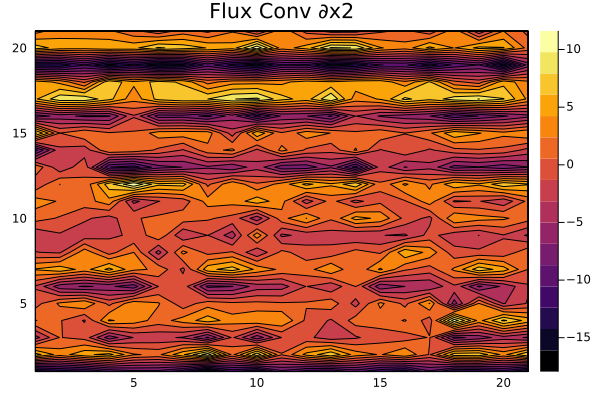

In [22]:
contourf(conv∂x2[:,:,1,1], title="Flux Conv ∂x2")

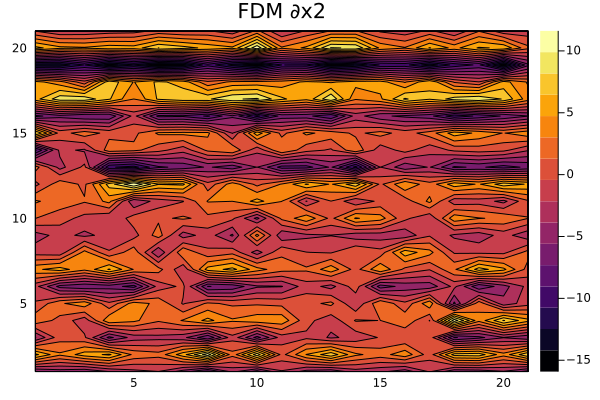

In [19]:
contourf(∂x2, title="FDM ∂x2")

### b) NNlib: Use same weights
Flux internally calls NNlib for neural network primitives

In [20]:
out = NNlib.conv(ϕconvPadded,weight∂x)

21×21×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
  -5.7982     -4.78704    -5.35727    …  -4.99545    -4.03997    NaN
   6.94542     3.29959     5.61298        7.39844     3.66683      8.07487
  -3.98863     0.616615   -0.137048      -6.0965     -3.97431     -5.28805
   2.50275     0.707387   -1.48933        3.5417      8.31364      5.24115
  -0.259696    2.72929     4.14404        2.44129    -3.31117     -1.12073
  -1.52266    -6.21673    -7.04312    …  -7.20378    -4.59605     -1.56994
   4.37998     5.54701     3.45406        7.24536     5.18581      0.510845
  -1.24409    -1.5738      3.59883       -0.869173   -0.910141     1.96415
  -2.89936    -1.56169    -2.53724       -3.17801    -1.41615     -3.46307
   1.31851     0.332369   -0.992605       3.11421     2.68866      1.30963
   3.23128     2.216       1.44235    …  -1.19981    -2.7009       1.06222
  -0.980665    2.39103     0.901092       4.53787     7.49984      6.24654
   2.06675    -2.78496     0.0078814     -7.01794    -8.08784

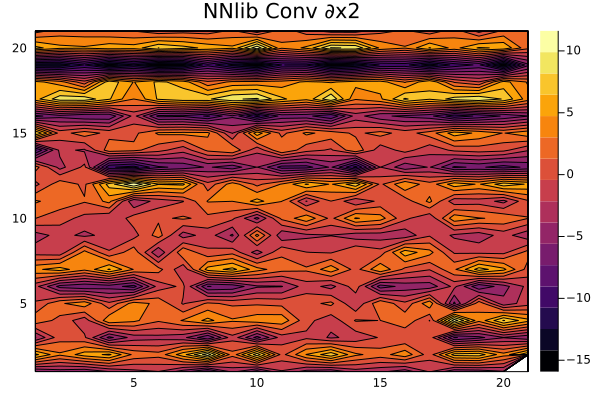

In [21]:
contourf(out[:,:,1,1], title="NNlib Conv ∂x2")

### c) Using DSP: Using signal processing package

In [24]:
outDSP = DSP.conv(ϕconv,weight∂x) #has implicit padding

23×23×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 -2.98023f-8    9.88337     8.74331   …    8.94654     9.68575f-8
  2.83047f-8  -15.6816    -13.5303       -15.2861     -4.86031f-7
  0.0           6.94542     3.29959        8.07487     2.68221f-7
  7.04515f-8   -3.98863     0.616616      -5.28805     1.91003f-7
  2.98023f-8    2.50275     0.707387       5.24115    -9.68575f-8
 -2.66723f-7   -0.259696    2.72929   …   -1.12073     9.19414f-9
  8.9407f-8    -1.52265    -6.21673       -1.56994     0.0
  2.16364f-7    4.37998     5.54701        0.510845    2.42034f-7
 -2.04891f-7   -1.24409    -1.5738         1.96415    -2.98023f-8
 -1.34033f-7   -2.89936    -1.56169       -3.46307    -1.99887f-7
  2.98023f-8    1.31851     0.33237   …    1.30963     1.19209f-7
  3.79683f-7    3.23128     2.216          1.06222     1.15594f-7
  1.19209f-7   -0.980664    2.39103        6.24654    -2.98023f-7
 -2.66723f-7    2.06675    -2.78496       -6.93196     1.72203f-7
  3.8743f-7    -9.39842    -1.73779    

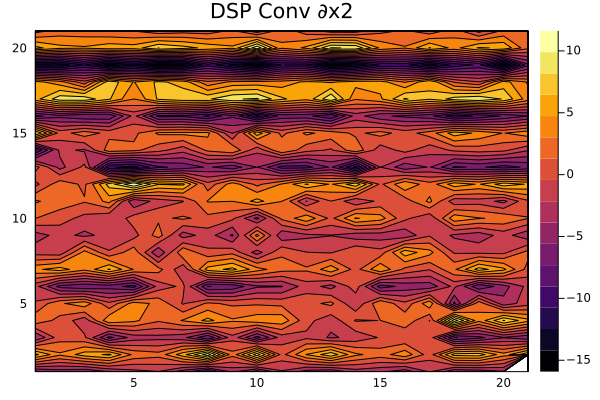

In [26]:
contourf(out[1:21,1:21,1,1], title="DSP Conv ∂x2")